# Smoking Status Detection

Key contents:


*   Data Cleaning: Sentence tokenization, sentence selection based on regex pattern, word tokenization, removal of punctuation, stop words and dates/numbers (for now. We should probably include numbers)
*   Data Preprocessing: TFIDF from scikit learn to create vectors of bigrams, unigrams and trigrams currently
*   Data Train Test split: Using test_set_labeled and train_set for this example. Used the same vectorizor on both sets
*   Tried to fit Multiclass Logistic Regression Model that gave pretty bad results
*   Checked metrics and confusion matrix



# Importing Training Data and Preprocessing


In [ ]:
from collections import Counter
import nltk
import pandas as pd
import numpy as np
import collections, numpy
import mlxtend
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
matplotlib.rcParams['figure.figsize'] = (10, 10)


from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from nltk.tokenize import sent_tokenize
import pandas as pd
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
import xml.etree.ElementTree as ET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/6001 Group 2 a/data/smoking_status_train.xml"
test_path = "/content/drive/MyDrive/6001 Group 2 a/data/smoking_status_test.xml"
test_path_labeled = "/content/drive/MyDrive/6001 Group 2 a/data/smoking_status_test_with_labels.xml"

def read_xml_custom(file_path, df_name):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract records into a list of dictionaries
    records = []
    for record in root.findall('RECORD'):
        record_id = record.get('ID')
        smoking_status = record.find('SMOKING').get('STATUS') if record.find('SMOKING') is not None else None
        text_content = record.find('TEXT').text.replace('\n', ' ').strip() if record.find('TEXT') is not None else None

        records.append({'ID': record_id, 'SMOKING': smoking_status, 'TEXT': text_content})

    # Create and return a DataFrame
    return pd.DataFrame(records)

# Example usage
train_set = read_xml_custom(train_path, 'train_set')

train_set.head()

,ID,SMOKING,TEXT
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))

# Function to process text
import string
string.punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Some Helper Functions for Preprocessing

In [ ]:
def process_text(text):
    # If input is a list, join into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Tokenize text (split by whitespace)
    words = text.split()

    # Step 1: Remove punctuations and convert to lowercase
    words_no_punc = [word.lower() for word in words if word not in string.punctuation]

    # Step 2: Remove stopwords
    clean_words = [word for word in words_no_punc if word not in stop_words]

    # Step 3: Remove numbers and dates (any word with digits)
    final_words = [word for word in clean_words if not re.search(r'\d', word)]

    return final_words


def select_smoking_sentences(text, pattern):
    # Tokenize text into sentences
    sentences = nltk.sent_tokenize(text)

    # Select sentences matching the smoking pattern
    smoking_sentences = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]

    return smoking_sentences


In [ ]:
def select_text_sentences(text):
    # Tokenize text into sentences
    sentences = nltk.sent_tokenize(text)

    return sentences

### Smoking Related Sentence Selection

In [ ]:
# Apply to each row in the DataFrame
smoking_patt = r'\b(smok[a-z]*|cig[a-z]*|cigarette[s]?|ciggie[s]?|cigar[s]?|cigs?|carton[s]?|pipes?|packs?|tobaccos?|nicotine|vape|e-cigarette[s]?|chewing\s+tobacco|snuff|hookah)\b' #reg exp for smoking related terms to pattern match sentences after tokenizing

train_set['SENTENCE_SMOKING'] = train_set['TEXT'].apply(lambda x: select_smoking_sentences(x, smoking_patt))
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS,SENTENCE_SMOKING
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor...","[Drinks ginger brandy to excess , pipe and cig..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass...",[HABITS : The patient has a 20 pack-year smoki...
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report...",[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi...",[SOCIAL HISTORY : Smoker for greater than 100 ...
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi...",[1-2 packs per day .]


In [ ]:
train_set['SENTENCES'] = train_set['TEXT'].apply(lambda x: select_text_sentences(x))
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor...","[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ...","[0.12748598, 0.122761145, 0.029220467, 0.11629..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass...",[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack-year, smoking, history]","[0.03925926, 0.01574213, 0.26988855, 0.0010694..."
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report...",[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]","[0.02648106, 0.11428968, 0.096110485, 0.029220..."
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi...",[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years...","[0.11428968, 0.096110485, 0.018545128, 0.11629..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi...",[1-2 packs per day .],"[packs, per, day]","[0.11428968, 0.096110485, 0.029220467, 0.11629..."


In [ ]:
train_set['SENTENCES'][0]

['977146916 HLGMC 2878891 022690 01/27/1997 12:00:00 AM CARCINOMA OF THE COLON .',
 'Unsigned DIS Report Status : Unsigned Please do not go above this box important format codes are contained .',
 'DISCHARGE SUMMARY ARF32 FA DISCHARGE SUMMARY NAME : GIRRESNET , DIEDREO A UNIT NUMBER : 075-71-01 ADMISSION DATE : 01/27/1997 DISCHARGE DATE : 01/31/1997 PRINCIPAL DIAGNOSIS : Carcinoma of the colon .',
 'ASSOCIATED DIAGNOSIS : Urinary tract infection , and cirrhosis of the liver .',
 'HISTORY OF PRESENT ILLNESS : The patient is an 80-year-old male , who had a history of colon cancer in the past , resected approximately ten years prior to admission , history of heavy alcohol use , who presented with a two week history of poor PO intake , weight loss , and was noted to have acute on chronic Hepatitis by chemistries and question of pyelonephritis .',
 'He lived alone but was driven to the hospital by his son because of reported worsening and general care and deconditioning .',
 'Emergency Depa

In [ ]:
train_set['SENTENCE_SMOKING'][0]

['Drinks ginger brandy to excess , pipe and cigar smoker for many years .']

In [ ]:
# Check for nulls in sentence_smoking field

train_set['SENTENCE_SMOKING'].isnull().sum()

0

### Cleaning Those Sentences and Creating Tokens

In [ ]:
# Now clean those sentences and create word tokens

train_set['CLEANED_TOKENS'] = train_set['SENTENCE_SMOKING'].apply(process_text)
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS,SENTENCE_SMOKING,CLEANED_TOKENS
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor...","[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass...",[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack-year, smoking, history]"
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report...",[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]"
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi...",[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi...",[1-2 packs per day .],"[packs, per, day]"


In [ ]:
train_set['CLEANED_TOKENS'][0]

['drinks',
 'ginger',
 'brandy',
 'excess',
 'pipe',
 'cigar',
 'smoker',
 'many',
 'years']

In [ ]:
train_set['CLEANED_TOTAL_TOKENS'] = train_set['SENTENCES'].apply(process_text)

In [ ]:
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass..."
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report..."
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi..."


In [ ]:
past_smoker_records = train_set.loc[train_set['SMOKING'] == 'PAST SMOKER']

# Display the selected records
past_smoker_records['CLEANED_TOKENS'][62]

['social',
 'history',
 'patient',
 "'s",
 'social',
 'history',
 'remarkable',
 'greater',
 'pack',
 'years',
 'smoking',
 'discontinued',
 'years',
 'prior',
 'admission']

In [ ]:
past_smoker_records['SENTENCE_SMOKING'][62]

["SOCIAL HISTORY : The patient 's social history is remarkable for greater than 80 pack years of smoking , which he discontinued 15 years prior to admission ."]

### Vectorize the cleaned tokens into TF-IDF form

In [ ]:
from gensim.models import Word2Vec

In [ ]:
import gensim.downloader as api

In [ ]:
w2v_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
w2v_model = Word2Vec(list(train_set['CLEANED_TOTAL_TOKENS']), vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
def word2vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model[word] for word in sentence if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=None, use_idf=True) #using unigrams, bigrams and trigrams in my vectorizer

In [ ]:
train_tfidf = vectorizer.fit_transform(train_set['CLEANED_TOKENS'].apply(lambda x: ' '.join(x)))

In [ ]:
print(train_tfidf)

  (0, 1032)	0.16050536962513137
  (0, 1365)	0.2156275811527769
  (0, 350)	0.2156275811527769
  (0, 1183)	0.2156275811527769
  (0, 2745)	0.20174066244435915
  (0, 543)	0.2156275811527769
  (0, 3373)	0.13852228757512108
  (0, 2116)	0.191887736818657
  (0, 4175)	0.12403971288445542
  (0, 1039)	0.2156275811527769
  (0, 1366)	0.2156275811527769
  (0, 351)	0.2156275811527769
  (0, 1184)	0.2156275811527769
  (0, 2746)	0.2156275811527769
  (0, 544)	0.2156275811527769
  (0, 3391)	0.20174066244435915
  (0, 2117)	0.191887736818657
  (0, 1040)	0.2156275811527769
  (0, 1367)	0.2156275811527769
  (0, 352)	0.2156275811527769
  (0, 1185)	0.2156275811527769
  (0, 2747)	0.2156275811527769
  (0, 545)	0.2156275811527769
  (0, 3392)	0.20174066244435915
  (1, 1396)	0.2328718044479942
  :	:
  (395, 2703)	0.10628214610591576
  (395, 2517)	0.10628214610591576
  (395, 2965)	0.10628214610591576
  (395, 2779)	0.10628214610591576
  (395, 1751)	0.10628214610591576
  (395, 2255)	0.10628214610591576
  (395, 2971)	0.1

In [ ]:
from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = "/content/drive/MyDrive/HIDS_6001/Lecture 11/glove.6B.100d.txt"

In [ ]:
wv = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [ ]:
w2v_model.similarity(train_set['CLEANED_TOKENS'][0], 'smoking')

array([0.0896243 , 0.02613975, 0.06526766, 0.01144959, 0.06917202,
       0.17689097, 0.27313128, 0.0165921 , 0.00518873], dtype=float32)

In [ ]:
train_set['CLEANED_TOKENS'][0]

['drinks',
 'ginger',
 'brandy',
 'excess',
 'pipe',
 'cigar',
 'smoker',
 'many',
 'years']

In [ ]:
w2v_model.similarity(train_set['CLEANED_TOKENS'][0][6], 'smoking')

0.6670884

In [ ]:
for x in train_set['CLEANED_TOKENS'][0]:
  print(w2v_model.similarity(x, 'smoking'))

0.26205346
0.079535685
0.1710378
0.042341277
0.2000311
0.44507158
0.6670884
0.077090934
0.02038779


In [ ]:
for x in train_set['CLEANED_TOKENS'][0]:
  print(w2v_model.similarity(x, 'smokers'))

0.24537756
0.10675183
0.17815278
0.06222171
0.12715676
0.33369648
0.733507
0.09763358
0.026730845


In [ ]:
for x in train_set['CLEANED_TOKENS'][1]:
  print(w2v_model.similarity(x, 'smokers'))

0.25744691
0.28166947


KeyError: "Key 'pack-year' not present"

In [ ]:
print(train_set['CLEANED_TOKENS'][30:40])

30         [note, patient, smoke, drink, smoking, none]
31                       [smoke, rare, alcohol, intake]
32    [cardiac, risk, factors, include, hypertension...
33    [denies, tobacco, drug, use, drinks, ethanol, ...
34                               [habits, smoke, drink]
35    [social, history, denies, alcohol, tobacco, li...
36                             [tobacco, history, none]
37                                            [tobacco]
38    [social, history, patient, psychologist, lived...
39                                             [smoker]
Name: CLEANED_TOKENS, dtype: object


In [ ]:
w2v_model.similarity('pack-year', 'smoking')

KeyError: "Key 'pack-year' not present"

In [ ]:
w2v_model.similarity(train_set['CLEANED_TOKENS'][0], 'smokers')

array([0.08392099, 0.03508447, 0.06798273, 0.0168255 , 0.04397161,
       0.13262564, 0.3003256 , 0.02101345, 0.00680306], dtype=float32)

In [ ]:
w2v_model.similarity(train_set['CLEANED_TOKENS'][1], 'smokers')

KeyError: "Key 'pack-year' not present"

In [ ]:
w2v_model.similarity('smoker', 'smoking')

0.6670884

In [ ]:
def get_similarity(row):
  token_similarity = []
  try:
    for token in row:
      #if token not in w2v_model.wv.index_to_key or token == 'htn' or token == '*************************************************':
      if token not in w2v_model.index_to_key:
        pass
      else:
        token_similarity.append(w2v_model.similarity(token, 'smoking'))
  except:
    print("error at", token)
  return token_similarity

In [ ]:
#sim_train = train_set['CLEANED_TOKENS'].apply(get_similarity)

In [ ]:
sim_train = train_set['CLEANED_TOKENS'].apply(get_similarity)

In [ ]:
print(w2v_model.key_to_index['smoking'])

4155


In [ ]:
print(type(w2v_model.wv.index_to_key))

<class 'list'>


In [ ]:
print(sim_train)

0      [0.26205346, 0.079535685, 0.1710378, 0.0423412...
1             [0.24519642, 0.17241281, 1.0, 0.019583065]
2              [1.0, 0.018903175, 0.537478, 0.031067071]
3      [0.17622778, 0.019583065, 0.6670884, 0.0481523...
4                 [0.12061692, 0.045590006, 0.031067071]
                             ...                        
393                                                   []
394                                                   []
395    [0.0991353, 0.07093696, -0.050828684, 0.127387...
396                                                   []
397                                                   []
Name: CLEANED_TOKENS, Length: 398, dtype: object


In [ ]:
print(sim_train[0], train_set['CLEANED_TOKENS'][0])

[0.26205346, 0.079535685, 0.1710378, 0.042341277, 0.2000311, 0.44507158, 0.6670884, 0.077090934, 0.02038779] ['drinks', 'ginger', 'brandy', 'excess', 'pipe', 'cigar', 'smoker', 'many', 'years']


In [ ]:
train_set['SIMILARITY_SCORES'] = sim_train

In [ ]:
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor...","[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ...","[0.12748598, 0.122761145, 0.029220467, 0.11629..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass...",[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack-year, smoking, history]","[0.03925926, 0.01574213, 0.26988855, 0.0010694..."
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report...",[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]","[0.02648106, 0.11428968, 0.096110485, 0.029220..."
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi...",[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years...","[0.11428968, 0.096110485, 0.018545128, 0.11629..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi...",[1-2 packs per day .],"[packs, per, day]","[0.11428968, 0.096110485, 0.029220467, 0.11629..."


# Importing and Preparing Test Set


In [ ]:
test_set_labeled = read_xml_custom(test_path_labeled, 'test_set')
test_set_labeled.head()

,ID,SMOKING,TEXT
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...


In [ ]:
test_set_labeled['SENTENCE_SMOKING'] = test_set_labeled['TEXT'].apply(lambda x: select_smoking_sentences(x, smoking_patt))
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...


In [ ]:
test_set_labeled['SENTENCE_SMOKING'].isnull().sum()

0

In [ ]:
test_set_labeled['CLEANED_TOKENS'] = test_set_labeled['SENTENCE_SMOKING'].apply(process_text)
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]"
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ..."
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d., social, history,..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]"


In [ ]:
test_set_labeled['SENTENCES'] = test_set_labeled['TEXT'].apply(lambda x: select_text_sentences(x))
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES,SENTENCES
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]","[0.077006936, 0.6670884, 0.26205346, 0.1443675...",[156406283 HLGMC 7213645 64723/51cy 5/28/1993 ...
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy...","[0.019583065, 0.6050037, 0.20251405, 0.6050037...",[487197293 PUOMC 2466262 408602 1976045 4/26/2...
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ...","[0.08743751, 0.101945885, 1.0, 0.041650176, 0....",[176318078 FIH 4189699 28872/d70h 094756 11/03...
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d., social, history,...","[0.1323883, 0.15089478, 0.17622778, 0.01958306...",[245096078 FIH 9174858 12/February 997359 11/3...
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]","[0.6670884, 0.058062065, 0.031067071, 0.106544...",[237073320 FIH 9746390 797120 251605 01/26/199...


In [ ]:
test_set_labeled['CLEANED_TOTAL_TOKENS'] = test_set_labeled['SENTENCES'].apply(process_text)

In [ ]:
sim_test = test_set_labeled['CLEANED_TOKENS'].apply(get_similarity)

In [ ]:
print(sim_test[0], test_set_labeled['CLEANED_TOKENS'][0])

[0.077006936, 0.6670884, 0.26205346, 0.14436759, 0.045590006, 0.031067071, 0.05767771] ['heavy', 'smoker', 'drinks', 'shots', 'per', 'day', 'times']


In [ ]:
test_set_labeled['SIMILARITY_SCORES'] = sim_test

In [ ]:
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES,SENTENCES,CLEANED_TOTAL_TOKENS
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]","[0.11428968, 0.096110485, 0.029220467, 0.11629...",[156406283 HLGMC 7213645 64723/51cy 5/28/1993 ...,"[hlgmc, discharge, summary, unsigned, dis, rep..."
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy...","[0.11428968, 0.096110485, 0.018545128, 0.11629...",[487197293 PUOMC 2466262 408602 1976045 4/26/2...,"[puomc, discharge, summary, signed, dis, repor..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ...","[0.024588915, 0.0070324778, 0.09148814, 0.0292...",[176318078 FIH 4189699 28872/d70h 094756 11/03...,"[fih, mitral, stenosis, unsigned, dis, report,..."
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d., social, history,...","[0.024588915, 0.11428968, 0.096110485, 0.02922...",[245096078 FIH 9174858 12/February 997359 11/3...,"[fih, discharge, summary, unsigned, dis, repor..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]","[0.024588915, 0.11428968, 0.096110485, 0.02922...",[237073320 FIH 9746390 797120 251605 01/26/199...,"[fih, discharge, summary, unsigned, dis, repor..."


In [ ]:
#train_w2v = np.array([word2vectorize(sentence) for sentence in train_set['SENTENCE_SMOKING']])
#test_w2v = np.array([word2vectorize(sentence) for sentence in test_set_labeled['SENTENCE_SMOKING']])

In [ ]:
#print(train_set['SIMILARITY_SCORES'].apply(np.array))

0                      [0.4800113, 0.5009442, 0.3977527]
1                 [0.5053161, 0.3903226, 1.0, 0.2378535]
2               [1.0, 0.14652587, 0.6744139, 0.33517468]
3      [0.34122714, 0.2378535, 0.5009442, 0.41649228,...
4                   [0.37071833, 0.25283098, 0.33517468]
                             ...                        
393                                                   []
394                                                   []
395    [0.30479035, 0.20460646, 0.19144662, 0.2892965...
396                                                   []
397                                                   []
Name: SIMILARITY_SCORES, Length: 398, dtype: object


In [ ]:
test_tfidf = vectorizer.transform(test_set_labeled['CLEANED_TOKENS'].apply(lambda x: ' '.join(x)))

In [ ]:
type(train_set['SIMILARITY_SCORES'][0])

list

In [ ]:
import statistics as st

In [ ]:
similarity_avg = []
for row in train_set['SIMILARITY_SCORES']:
  if len(row) == 0:
    similarity_avg.append(0)
  else:
    similarity_avg.append(st.mean(row))

In [ ]:
test_avg = []
for row in test_set_labeled['SIMILARITY_SCORES']:
  if len(row) == 0:
    test_avg.append(0)
  else:
    test_avg.append(st.mean(row))

In [ ]:
print(similarity_avg)

[0.21829312, 0.35929808, 0.39686206, 0.11997591, 0.065758, 0.18040913, 0.26285845, 0.20445351, 0.31038883, 0.2523428, 0.19025367, 0.13451956, 0.18266866, 0.16186471, 0.12352417, 0.13573347, 0.23970045, 0.28522637, 0, 0.17652035, 0.24720149, 0.34610808, 0.27562723, 0.24112976, 0.3376351, 0.22730714, 0.33374235, 0.45759737, 0.25221837, 0.34899303, 0.38373524, 0.31793648, 0.21397033, 0.23846313, 0.39789975, 0.18913846, 0.2412407, 0.6050037, 0.17750466, 0.6670884, 0.28964594, 0.21373202, 0.25453123, 0.30106992, 0.4827205, 0.23357339, 0.23357339, 0.2726915, 0.40146995, 0.2233324, 0.34152803, 0.30384848, 0.6050037, 0.20680365, 0.25697765, 0.21647376, 0.2515903, 0.23242521, 0.46446797, 0.22296716, 0.33504212, 0.18507174, 0.14227352, 0.22512636, 0.17544052, 0.19566269, 0.19376929, 0.25443614, 0.12853612, 0.21442337, 0.12975256, 0.17796293, 0.14042611, 0.24948554, 0.16427702, 0.12904298, 0.20636326, 0.21832229, 0.21173637, 0.28730363, 0.2213825, 0.22242743, 0.15312217, 0.17866321, 0.4298284, 0.

In [ ]:
train_set['SIMILARITY_AVG'] = similarity_avg

In [ ]:
train_set.head()

,ID,SMOKING,TEXT,SENTENCES,CLEANED_TOTAL_TOKENS,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES,SIMILARITY_AVG
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,[977146916 HLGMC 2878891 022690 01/27/1997 12:...,"[hlgmc, carcinoma, colon, unsigned, dis, repor...","[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ...","[0.12748598, 0.122761145, 0.029220467, 0.11629...",0.082818
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[026738007 CMC 15319689 3/25/1998 12:00:00 AM ...,"[cmc, mediastinal, adenopathy, rt., lung, mass...",[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack-year, smoking, history]","[0.03925926, 0.01574213, 0.26988855, 0.0010694...",0.087250
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[071962960 BH 4236518 417454 12/10/2001 12:00:...,"[bh, discharge, summary, unsigned, dis, report...",[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]","[0.02648106, 0.11428968, 0.096110485, 0.029220...",0.082325
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[418520250 NVH 61562872 3/11/1995 12:00:00 AM ...,"[nvh, discharge, summary, signed, dis, admissi...",[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years...","[0.11428968, 0.096110485, 0.018545128, 0.11629...",0.079711
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[301443520 CTMC 49020928 448922 1/11/1990 12:0...,"[ctmc, discharge, summary, unsigned, dis, admi...",[1-2 packs per day .],"[packs, per, day]","[0.11428968, 0.096110485, 0.029220467, 0.11629...",0.075197


In [ ]:
test_set_labeled['SIMILARITY_AVG'] = test_avg

In [ ]:
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,SIMILARITY_SCORES,SENTENCES,CLEANED_TOTAL_TOKENS,SIMILARITY_AVG
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]","[0.11428968, 0.096110485, 0.029220467, 0.11629...",[156406283 HLGMC 7213645 64723/51cy 5/28/1993 ...,"[hlgmc, discharge, summary, unsigned, dis, rep...",0.078430
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy...","[0.11428968, 0.096110485, 0.018545128, 0.11629...",[487197293 PUOMC 2466262 408602 1976045 4/26/2...,"[puomc, discharge, summary, signed, dis, repor...",0.083584
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ...","[0.024588915, 0.0070324778, 0.09148814, 0.0292...",[176318078 FIH 4189699 28872/d70h 094756 11/03...,"[fih, mitral, stenosis, unsigned, dis, report,...",0.082514
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d., social, history,...","[0.024588915, 0.11428968, 0.096110485, 0.02922...",[245096078 FIH 9174858 12/February 997359 11/3...,"[fih, discharge, summary, unsigned, dis, repor...",0.073261
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]","[0.024588915, 0.11428968, 0.096110485, 0.02922...",[237073320 FIH 9746390 797120 251605 01/26/199...,"[fih, discharge, summary, unsigned, dis, repor...",0.076026


In [ ]:
train_w2v = train_set[['SIMILARITY_AVG']]
test_w2v = test_set_labeled[['SIMILARITY_AVG']]

# Model Training and Testing
### Multi Class Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#X_train = train_tfidf
#y_train = train_set['SMOKING']
#X_test = test_tfidf
#y_test = test_set_labeled['SMOKING']

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training data and transform it
train_set['SMOKING_encoded'] = label_encoder.fit_transform(train_set['SMOKING'])

#val_set['SMOKING_encoded'] = label_encoder.transform(val_set['SMOKING'])

# Apply the same encoding to the test data (using transform, not fit_transform)
test_set_labeled['SMOKING_encoded'] = label_encoder.transform(test_set_labeled['SMOKING'])

In [ ]:
#X_train = train_set.drop('SMOKING', axis=1)
X_train = train_w2v
y_train = train_set['SMOKING']
#X_test = test_set_labeled.drop('SMOKING', axis=1)
X_test = test_w2v
y_test = test_set_labeled['SMOKING']

In [ ]:
X_train[:3]

,SIMILARITY_AVG
0,0.218293
1,0.359298
2,0.396862


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (398, 1)
Shape of X_test: (104, 1)
Shape of y_train: (398,)
Shape of y_test: (104,)


In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(train_w2v, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

CURRENT SMOKER       0.00      0.00      0.00        11
    NON-SMOKER       0.59      0.62      0.61        16
   PAST SMOKER       0.00      0.00      0.00        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.72      1.00      0.84        63

      accuracy                           0.70       104
     macro avg       0.26      0.33      0.29       104
  weighted avg       0.53      0.70      0.60       104



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: 

### Model Performance

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Print classification report (precision, recall, F1-score for each class)
print(classification_report(y_test, y_pred))

# Calculate and print overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


                precision    recall  f1-score   support

CURRENT SMOKER       0.25      0.09      0.13        11
    NON-SMOKER       0.87      0.81      0.84        16
   PAST SMOKER       0.80      0.36      0.50        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.79      1.00      0.88        63

      accuracy                           0.78       104
     macro avg       0.54      0.45      0.47       104
  weighted avg       0.72      0.78      0.73       104

Accuracy: 0.78
Confusion Matrix:
[[ 1  2  1  0  7]
 [ 0 13  0  0  3]
 [ 2  0  4  0  5]
 [ 1  0  0  0  2]
 [ 0  0  0  0 63]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


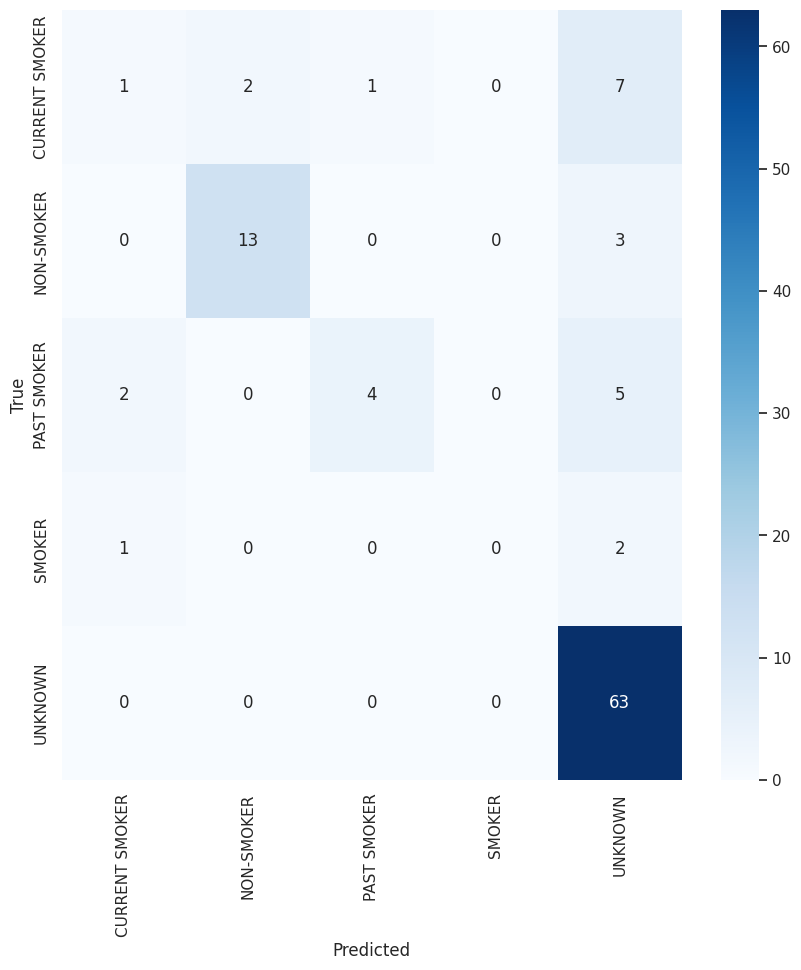

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MultiClass SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Initialize the SVM model
model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)  # 'linear' kernel is commonly used for text classification, One Vs Rest strategy "OVR"


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

CURRENT SMOKER       0.42      0.45      0.43        11
    NON-SMOKER       0.88      0.88      0.88        16
   PAST SMOKER       0.67      0.36      0.47        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.90      1.00      0.95        63

      accuracy                           0.83       104
     macro avg       0.57      0.54      0.55       104
  weighted avg       0.79      0.83      0.80       104



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[ 5  2  2  0  2]
 [ 0 14  0  0  2]
 [ 5  0  4  0  2]
 [ 2  0  0  0  1]
 [ 0  0  0  0 63]]


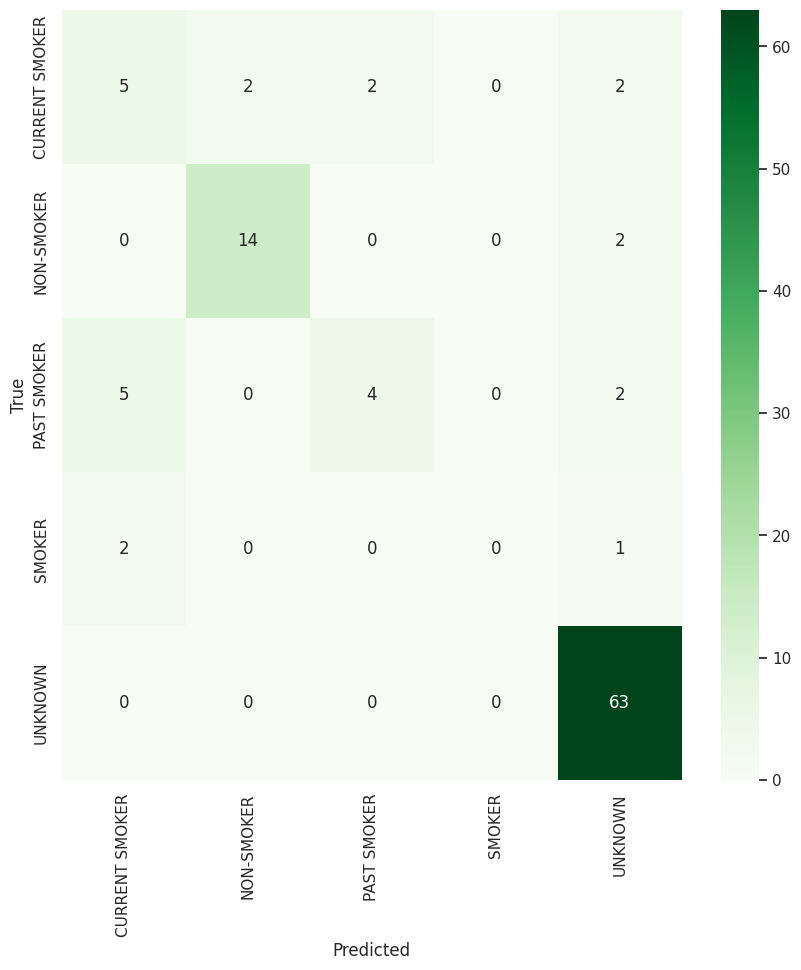

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_svm)

sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Greens", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MultiClass SVM with Scaling

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.43      0.27      0.33        11
    NON-SMOKER       0.80      0.75      0.77        16
   PAST SMOKER       0.60      0.27      0.38        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.82      1.00      0.90        63

      accuracy                           0.78       104
     macro avg       0.53      0.46      0.48       104
  weighted avg       0.73      0.78      0.74       104

Confusion Matrix:
[[ 3  2  2  0  4]
 [ 0 12  0  0  4]
 [ 4  0  3  0  4]
 [ 0  1  0  0  2]
 [ 0  0  0  0 63]]


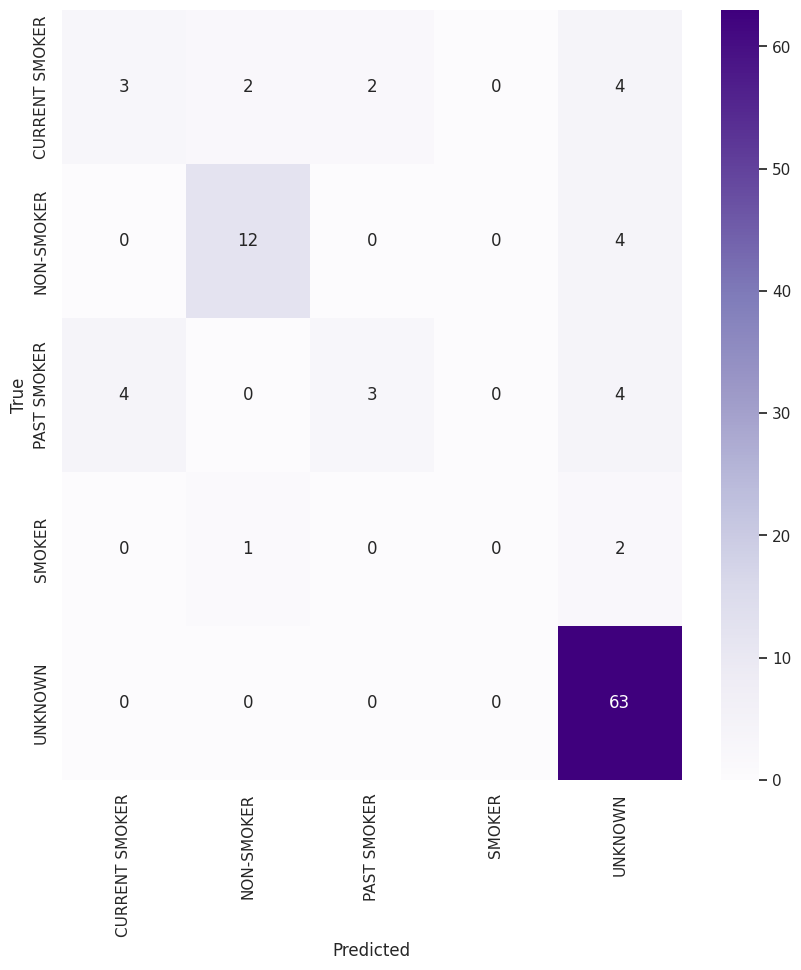

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.toarray())  # toarray() converts sparse matrix to dense
# Transform the test data using the same scaler (we don't fit it again)
X_test_scaled = scaler.transform(X_test.toarray())

# Initialize the SVM model
model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))

conf_matrix_svm_scaled = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_svm_scaled)

sns.heatmap(conf_matrix_svm_scaled, annot=True, fmt="d", cmap="Purples", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Naive-Bayes

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.00      0.00      0.00        11
    NON-SMOKER       0.81      0.81      0.81        16
   PAST SMOKER       0.75      0.27      0.40        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.75      1.00      0.86        63

      accuracy                           0.76       104
     macro avg       0.46      0.42      0.41       104
  weighted avg       0.66      0.76      0.69       104

Confusion Matrix:
[[ 0  2  1  0  8]
 [ 0 13  0  0  3]
 [ 0  1  3  0  7]
 [ 0  0  0  0  3]
 [ 0  0  0  0 63]]


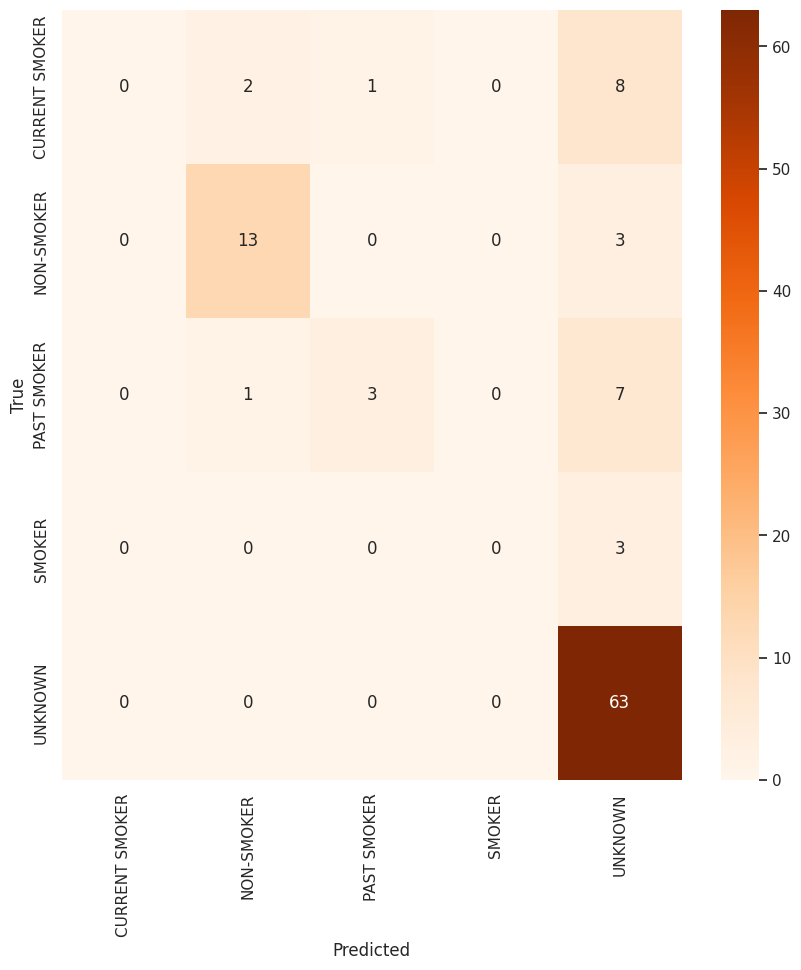

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Convert the list of tokens in SENTENCE_SMOKING to a single string
train_set['STR_SMOKING'] = train_set['SENTENCE_SMOKING'].apply(lambda x: ' '.join(x))
test_set_labeled['STR_SMOKING'] = test_set_labeled['SENTENCE_SMOKING'].apply(lambda x: ' '.join(x))

# Create a pipeline that first vectorizes the text using TF-IDF, then applies Naive Bayes
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), stop_words='english'), MultinomialNB())

# Fit the model with training data
model.fit(train_set['STR_SMOKING'], train_set['SMOKING'])

# Predict on the test set
y_pred = model.predict(test_set_labeled['STR_SMOKING'])

# Print the classification report to evaluate performance
print(classification_report(test_set_labeled['SMOKING'], y_pred))

conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_nb)

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Oranges", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Naive-Bayes on other features


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.00      0.00      0.00        11
    NON-SMOKER       0.76      0.81      0.79        16
   PAST SMOKER       0.80      0.36      0.50        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.77      1.00      0.87        63

      accuracy                           0.77       104
     macro avg       0.47      0.44      0.43       104
  weighted avg       0.67      0.77      0.70       104

Confusion Matrix:
[[ 0  2  1  0  8]
 [ 0 13  0  0  3]
 [ 0  1  4  0  6]
 [ 0  1  0  0  2]
 [ 0  0  0  0 63]]


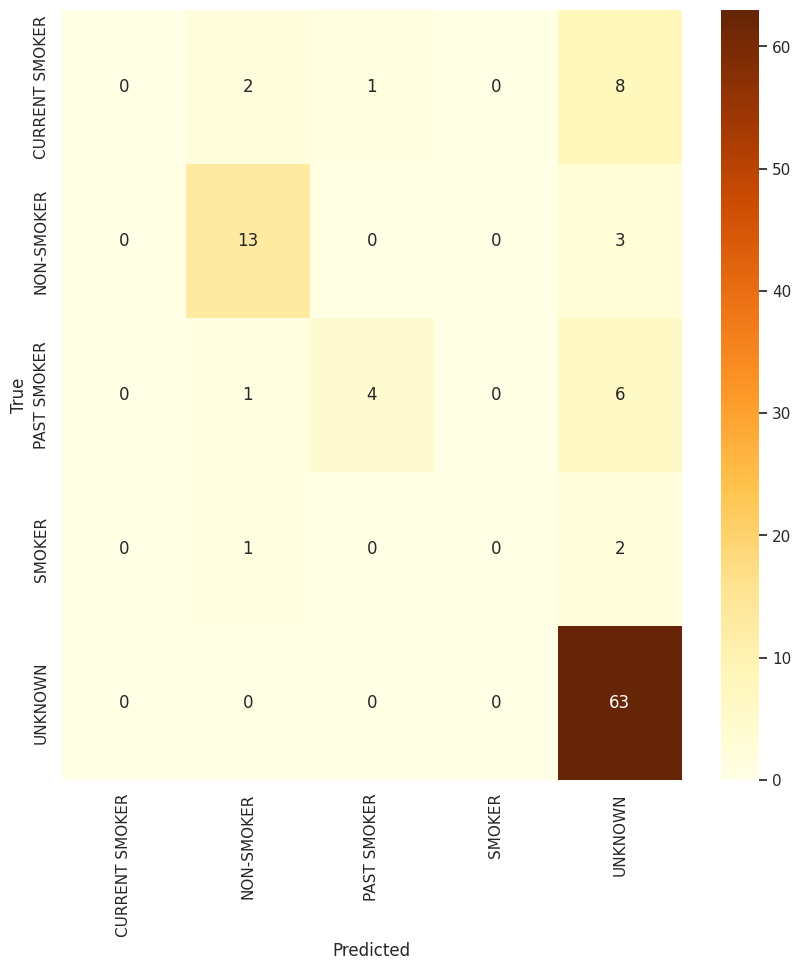

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Convert the list of tokens in SENTENCE_SMOKING to a single string
train_set['CLEAN_TOKENS_STR'] = train_set['CLEANED_TOKENS'].apply(lambda x: ' '.join(x))
test_set_labeled['CLEAN_TOKENS_STR'] = test_set_labeled['CLEANED_TOKENS'].apply(lambda x: ' '.join(x))

# Create a pipeline that first vectorizes the text using TF-IDF, then applies Naive Bayes
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), stop_words='english'), MultinomialNB())

# Fit the model with training data
model.fit(train_set['CLEAN_TOKENS_STR'], train_set['SMOKING'])

# Predict on the test set
y_pred = model.predict(test_set_labeled['CLEAN_TOKENS_STR'])

# Print the classification report to evaluate performance
print(classification_report(test_set_labeled['SMOKING'], y_pred))

conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_nb)

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="YlOrBr", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()